# Capstone

**Group Members**

> Alexis Mercado

> Christian Sibrian

> Gerardo Moreno

## Download


In [ ]:
from google.colab import files

!pip install -q kaggle
! mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list


ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              234KB  2021-07-16 07:08:29           9306  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5687  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2067  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2418  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
# Download Data
!kaggle datasets download navoneel/brain-mri-images-for-brain-tumor-detection
!ls

 40% 6.00M/15.1M [00:00<00:00, 61.9MB/s]
100% 15.1M/15.1M [00:00<00:00, 86.2MB/s]
brain-mri-images-for-brain-tumor-detection.zip	kaggle.json  sample_data


In [ ]:
!unzip brain-mri-images-for-brain-tumor-detection.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

## Load Data

In [ ]:
# Load Data
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
all_data_dir = pathlib.Path('/content/brain_tumor_dataset')
yes_dir = pathlib.Path('/content/yes')
no_dir = pathlib.Path('/content/no')


## Exploratory Data Analysis

In [ ]:
dataCount = len(list(all_data_dir.glob('*')))
print(dataCount)
yesCount = len(list(yes_dir.glob('*')))
print(yesCount)
noCount = len(list(no_dir.glob('*')))
print(noCount)

2
155
98


In [ ]:
image_count = len(list(all_data_dir.glob('*/*')))
print(image_count)

253


In [ ]:
image_iterator = tf.keras.preprocessing.image.DirectoryIterator(
    target_size=(100, 100),
    directory=all_data_dir,
    batch_size=128,
    image_data_generator=None)

Found 253 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcP

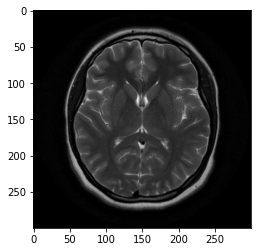

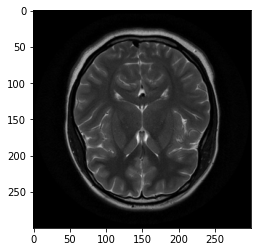

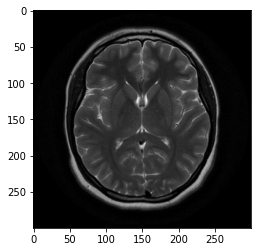

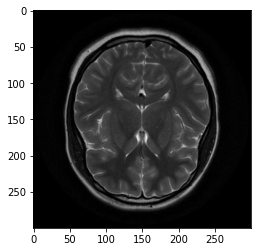

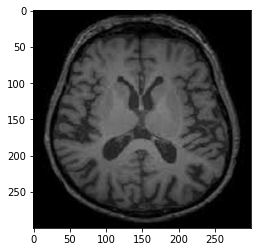

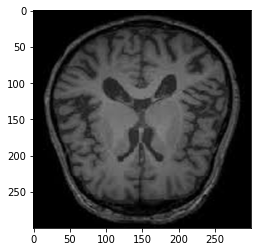

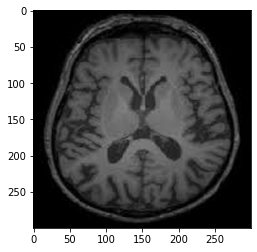

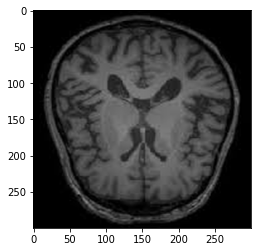

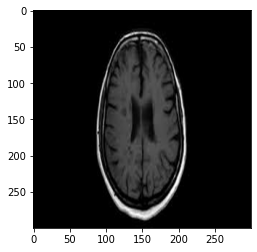

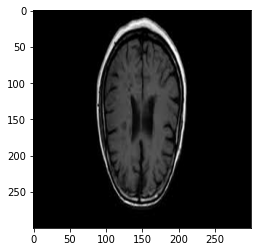

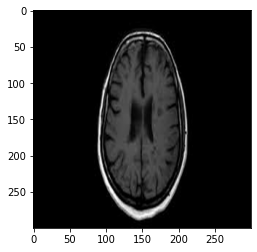

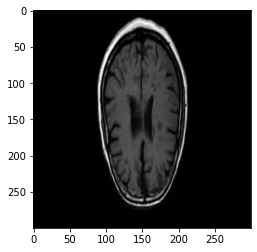

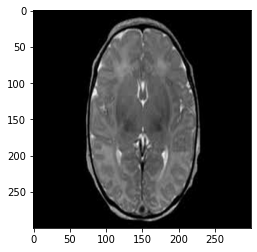

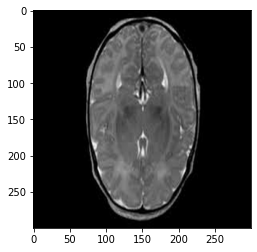

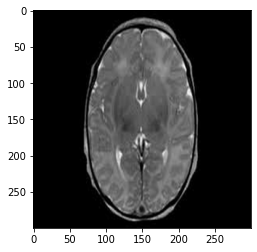

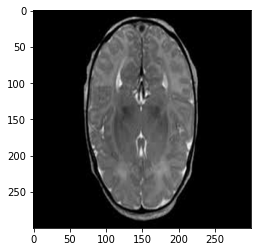

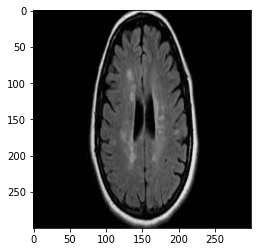

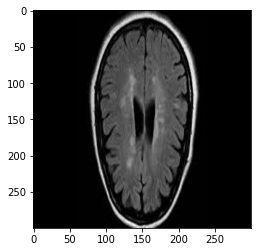

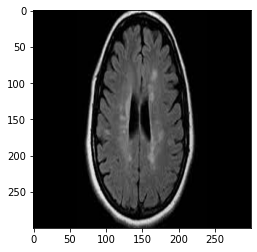

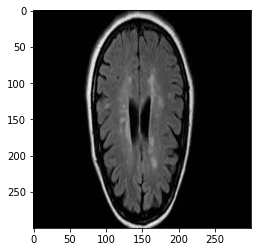

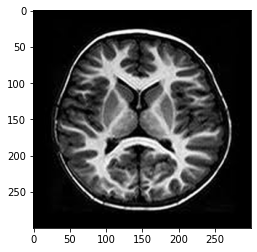

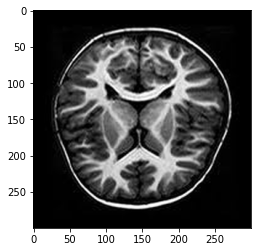

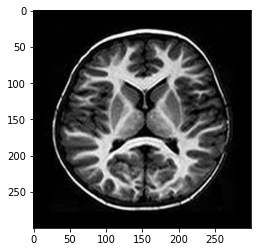

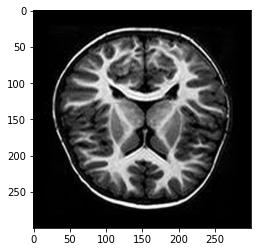

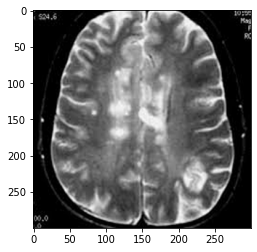

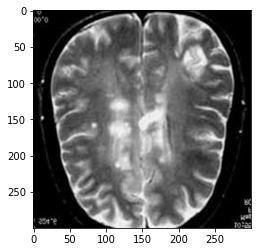

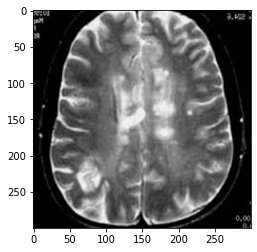

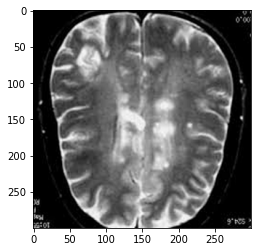

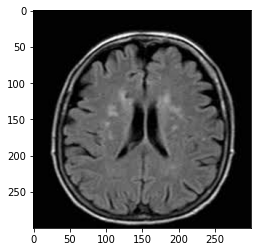

Error in callback <function flush_figures at 0x7f825eedb4d0> (for post_execute):


KeyboardInterrupt: ignored

In [40]:
from PIL import ImageOps, Image

arr = image_iterator.filepaths
j=0
for i in arr: 
  image = i
  img = PIL.Image.open(image)
  img = img.convert('RGB')
  img = img.resize((300, 300), Image.ANTIALIAS)
  flip = ImageOps.flip(img)
  mirror = ImageOps.mirror(img)
  rotate = img.rotate(180)

  plt.figure()
  plt.imshow(img)
  plt.figure()
  plt.imshow(flip)
  plt.figure()
  plt.imshow(mirror)
  plt.figure()
  plt.imshow(rotate)
  new = i.strip('.jpeg')
  #new = i.strip('.jpg')
  name = new + '-flipped.jpeg'
  name2 = new + '-mirror.jpeg'
  name3 = new + '-rotate.jpeg'
  flip.save(name)
  mirror.save(name2)
  rotate.save(name3)
  img.save(i)


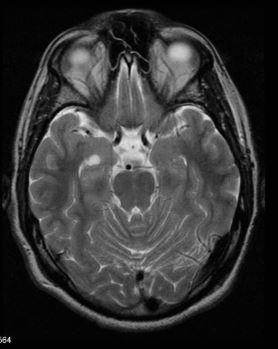

In [31]:
# yes = list(all_data_dir.glob('yes/*'))
# PIL.Image.open(str(yes[0]))

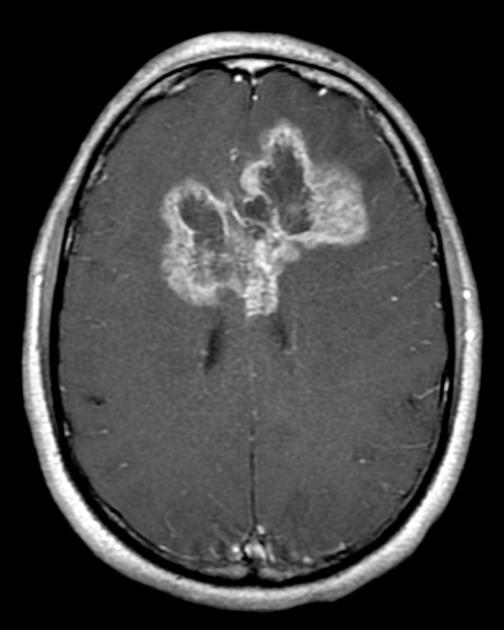

In [33]:
# yes = list(all_data_dir.glob('yes/*'))
# PIL.Image.open(str(yes[2]))

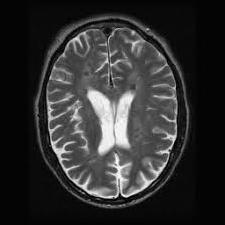

In [ ]:
# no = list(all_data_dir.glob('no/*'))
# PIL.Image.open(str(no[0]))

In [ ]:
batch_size = 32
img_height = 350
img_width = 300

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  all_data_dir,
  #labels=None,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1012 files belonging to 2 classes.
Using 810 files for training.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  all_data_dir,
  #labels=None,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1012 files belonging to 2 classes.
Using 202 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


In [ ]:
class_names = val_ds.class_names
print(class_names)

['no', 'yes']


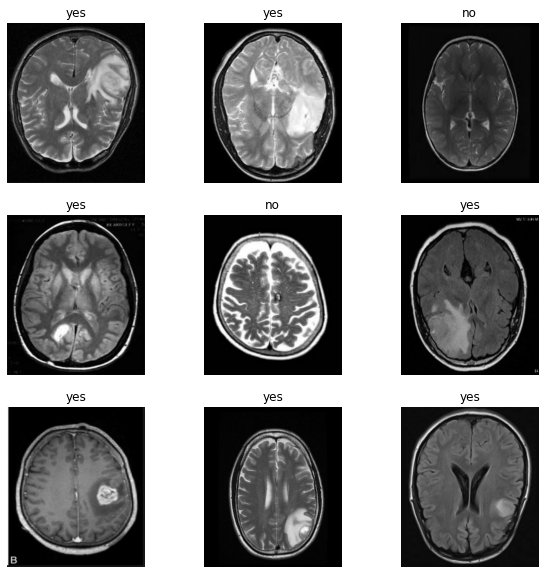

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image)) 

## Build Model

In [ ]:
num_classes = 1

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 350, 300, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 350, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 175, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 175, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 87, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 37, 64)        0

In [ ]:
train_ds

<BatchDataset shapes: ((None, 350, 300, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 83s 3s/step - loss: 0.9591 - accuracy: 0.7198 - val_loss: 0.4912 - val_accuracy: 0.7822
Epoch 2/10
26/26 [==============================] - 80s 3s/step - loss: 0.4192 - accuracy: 0.8222 - val_loss: 0.4259 - val_accuracy: 0.8267
Epoch 3/10
26/26 [==============================] - 81s 3s/step - loss: 0.3208 - accuracy: 0.8765 - val_loss: 0.3158 - val_accuracy: 0.8911
Epoch 4/10
26/26 [==============================] - 81s 3s/step - loss: 0.1865 - accuracy: 0.9309 - val_loss: 0.2921 - val_accuracy: 0.8663
Epoch 5/10
26/26 [==============================] - 81s 3s/step - loss: 0.1061 - accuracy: 0.9642 - val_loss: 0.2229 - val_accuracy: 0.8861
Epoch 6/10
26/26 [==============================] - 81s 3s/step - loss: 0.0605 - accuracy: 0.9827 - val_loss: 0.1917 - val_accuracy: 0.9109
Epoch 7/10
26/26 [==============================] - 81s 3s/step - loss: 0.0212 - accuracy: 0.9963 - val_loss: 0.2207 - val_accuracy: 0.9307
Epoch 8/10
26/26 [==

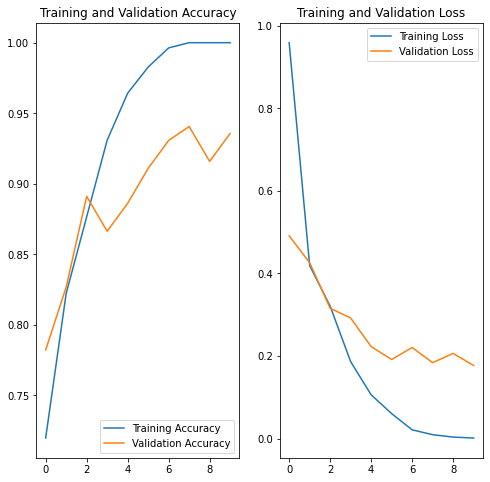

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.evaluate(val_ds)

7/7 [==============================] - 6s 755ms/step - loss: 0.1770 - accuracy: 0.9356


[0.17704054713249207, 0.9356435537338257]

In [ ]:
prediction = model.predict(val_ds)

prediction

array([[8.63955677e-01],
       [9.99993324e-01],
       [1.00000000e+00],
       [2.86634272e-09],
       [1.72447164e-06],
       [9.99744892e-01],
       [9.99835253e-01],
       [9.99992132e-01],
       [7.07079550e-07],
       [2.86604891e-08],
       [9.99999523e-01],
       [9.99970436e-01],
       [1.00000000e+00],
       [6.18993104e-01],
       [9.99998689e-01],
       [1.00000000e+00],
       [9.99997497e-01],
       [1.00000000e+00],
       [1.42568342e-06],
       [9.96515632e-01],
       [9.89755988e-01],
       [9.99825835e-01],
       [9.99999285e-01],
       [1.46158508e-09],
       [3.22401524e-04],
       [1.00000000e+00],
       [8.37698553e-06],
       [9.99977112e-01],
       [9.98928666e-01],
       [3.43859673e-01],
       [9.94596601e-01],
       [2.85411556e-10],
       [9.08911705e-01],
       [9.08471704e-01],
       [1.42349732e-08],
       [9.99988437e-01],
       [1.15767270e-01],
       [1.00000000e+00],
       [9.99999642e-01],
       [9.99757409e-01],


## Predictions